# Práctica 1

### Parte 3:  Umbralizacion y componentes conexas

In [25]:
from PIL import Image
import numpy as np
from skimage.filters import threshold_otsu
import math

In [3]:
im = Image.open("text1.png")
print(im.mode)
I = np.array(im)

L


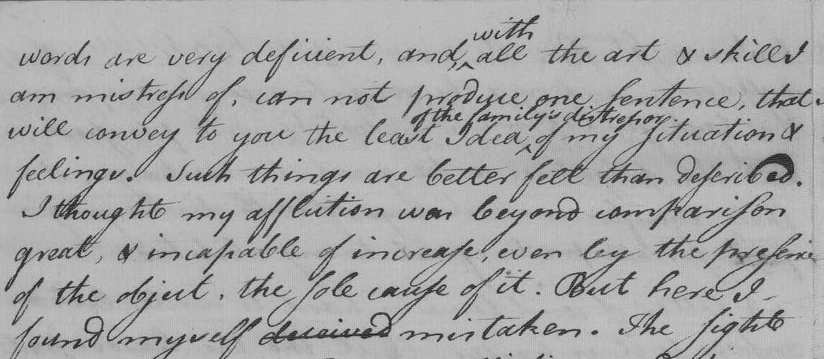

In [4]:
im

Umbralizacion de Otsu:
- Versión 1: calculando las dispersiones de los valores que caen a cada lado del umbral.

In [8]:
def Otsu_v1(I): 
    D = []
    for p in range(256):
        izq,der = [],[]
        for i in range(I.shape[0]):
            for j in range(I.shape[1]):
                if I[i,j] <= p:
                    izq.append(I[i,j])
                else:
                    der.append(I[i,j])
        
        p0 = len(izq) 
        try:
            media0 = sum(izq)/p0
            var0 = sum((valor - media0)**2 for valor in izq)/p0
        except ZeroDivisionError:
            var0 = 0
        
        p1 = len(der)
        try:
            media1 = sum(der)/p1
            var1 = sum((valor - media1)**2 for valor in der)/p1
        except ZeroDivisionError:
            var1 = 0
        
        d = p0 * var0 + p1 * var1
        D.append(d)
    
    t = D.index(min(D)) 
    print(t)
    mask = np.zeros(I.shape)
    mask[I<=t] = 255
    mask = 255 - mask
        
    return mask

- Versión 2: llamando a la función `threshold_otsu` de la librería de `skimage.filters` (más rápido).

In [9]:
def Otsu_v2(I): 
    th = threshold_otsu(I)
    mask = np.zeros(I.shape)
    mask[I<=th] = 255
    mask = 255 - mask
        
    return mask

Umbralizamos la imagen anterior, llamando a la última función creada. 

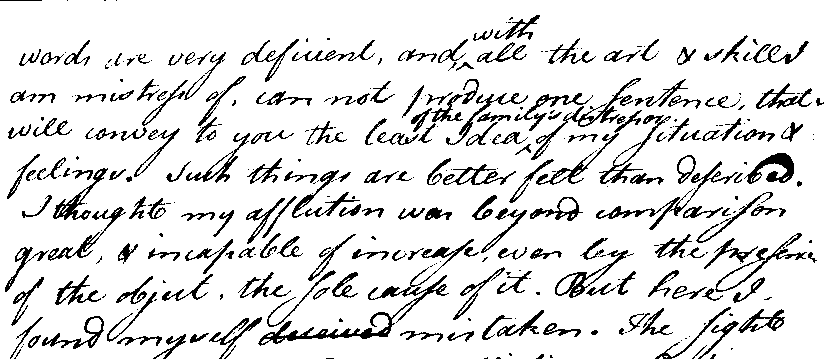

In [10]:
S = Otsu_v2(I)
S = np.uint8(S)
im2 = Image.fromarray(S)
im2

Ahora implementamos la umbralización de Otsu adaptativa sobre otra imagen.

L


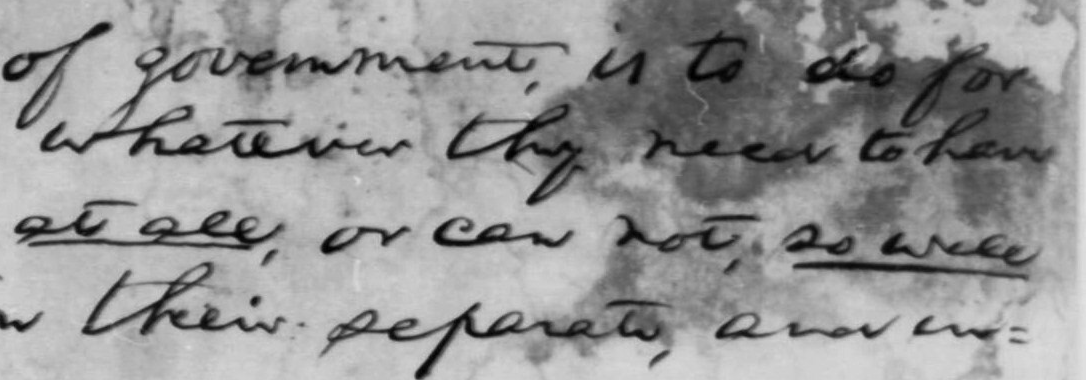

In [14]:
im3 = Image.open("text2.png")
I2 = np.array(im3)
print(im3.mode)
im3

In [16]:
def Otsu_Adap(I):
    tam_ventana = 60
    window_occ = np.zeros(I.shape) #Matriz que cuenta el total de ventanas atravesadas por cada píxel 
    count_mat = np.zeros(I.shape) #Matriz que cuenta las veces que cada píxel cae en el lado izquierdo del umbral por ventana distinta 
    for i in range(I.shape[0] - tam_ventana + 1):
        for j in range(I.shape[1] - tam_ventana + 1):
            v = I[i:i+tam_ventana , j:j+tam_ventana]
            th = threshold_otsu(v)   #Calculamos el umbral de la ventana
            local_mat = np.zeros(v.shape)
            local_mat[v <= th] = 1
            count_mat[i:i+tam_ventana , j:j+tam_ventana] += local_mat       #Actualizamos las matrices
            window_occ[i:i+tam_ventana , j:j+tam_ventana] += np.ones(v.shape)
    
    mask = count_mat/window_occ * 255
    
    return mask      

Aplicamos Otsu adaptativo a la imagen anterior:

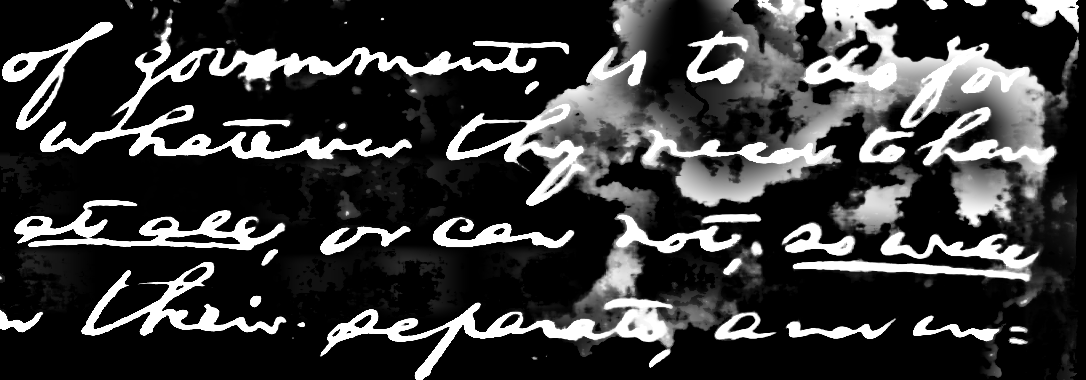

In [17]:
S2 = Otsu_Adap(I2)
S2 = np.uint8(S2)
im4 = Image.fromarray(S2)
im4

Y aplicamos Otsu sobre la anterior:

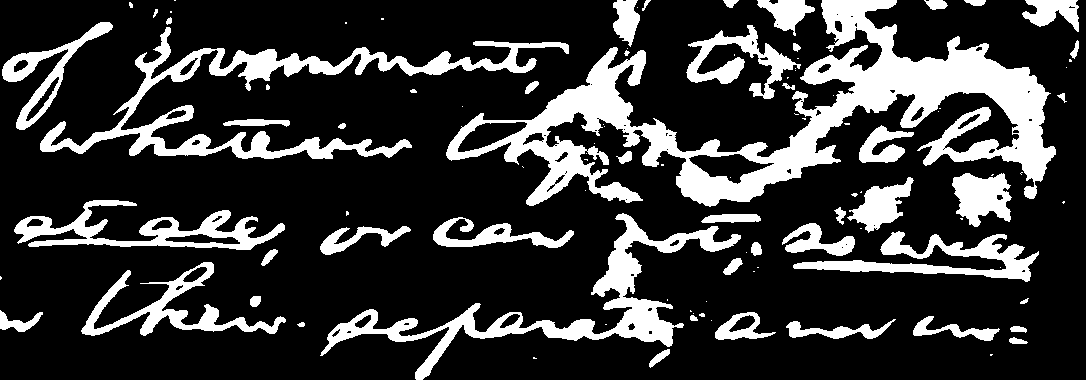

In [18]:
S3 = Otsu_v2(S2)
S3 = np.uint8(S3)
im5 = Image.fromarray(S3)
im5

Implementación del algoritmo de dos pasadas de componentes conexas:

In [19]:
im = Image.open("componentes.png")
im.mode

'RGBA'

L


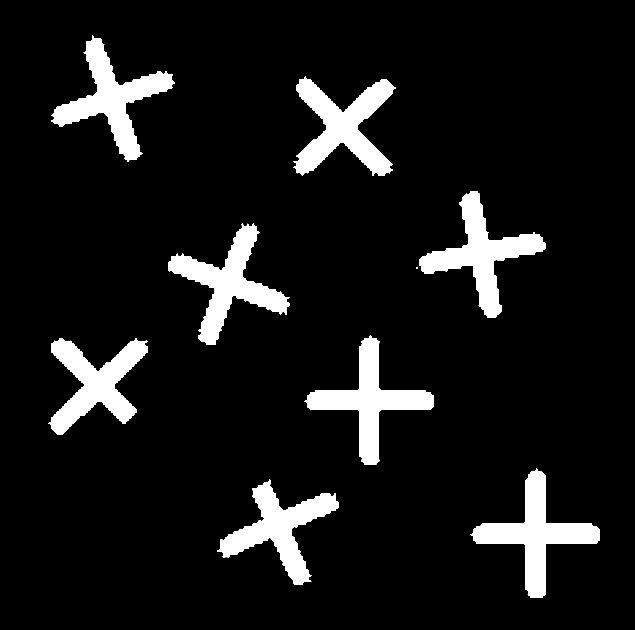

In [20]:
im = Image.open("componentes.png").convert('L')  #Pasamos la imagen a escala de grises 
I = np.array(im)
print(im.mode)
im

Comprobamos si la imagen está umbralizada

In [21]:
np.histogram(I, bins = 256, range = (0,255))[0]

array([363242,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      1,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      1,      0,      0,
            1,      0,      0,      0,      0,      0,      0,      0,
            2,      0,      0,      0,      1,      0,      1,      1,
            0,      0,      0,      0,      0,      0,      1,      1,
            0,      0,      1,      1,      0,      2,      2,      1,
            1,      1,      1,      0,      2,      0,      1,      0,
            0,      0,      0,      0,      0,      1,      1,      1,
            1,      0,      0,      0,      0,      3,      0,      0,
            2,      0,      0,      0,      2,      1,      2,      0,
            0,      0,      0,      1,      1,      0,      1,      3,
      

In [22]:
def union_find(lis):
    #Función que encuentra la unión de varios conjuntos que comparten elementos entre sí. 
    #Necesaria para la resolución de equivalencias en componentes conexas.
    lis = map(set, lis)
    unions = []
    for item in lis:
        temp = []
        for s in unions:
            if not s.isdisjoint(item):
                item = s.union(item)
            else:
                temp.append(s)
        temp.append(item)
        unions = temp
    return unions

In [23]:
def Label(I, bounding_box = False):
    
    #A continuación aplicamos componentes conexas. Empezamos con la primera pasada
    comp_mat = np.zeros(I.shape)
    equivalencias = []
    componentes = 0

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i,j] == 0:
                pass
            
            elif i == 0 and j == 0:
                componentes += 1
                comp_mat[i,j] = componentes
            
            elif i == 0:
                if I[i,j] == I[i,j-1]:
                    comp_mat[i,j] = comp_mat[i,j-1]
                
                else:  #Creamos componente
                    componentes += 1
                    comp_mat[i,j] = componentes
            
            elif j == 0:
                if I[i,j] == I[i-1,j+1]:
                    comp_mat[i,j] = comp_mat[i-1,j+1]
                
                elif I[i,j] == I[i-1,j]:
                    comp_mat[i,j] = comp_mat[i-1,j]
                
                else:  #Creamos componente
                    componentes += 1
                    comp_mat[i,j] = componentes
        
            elif j == I.shape[1] - 1:
                if I[i,j] == I[i-1,j]:
                    comp_mat[i,j] = comp_mat[i-1,j]
                    
                elif I[i,j] == I[i-1,j-1]:
                    comp_mat[i,j] = comp_mat[i-1,j-1] 
                
                elif I[i,j] == I[i,j-1]:
                    comp_mat[i,j] = comp_mat[i,j-1]
                
                else:  #Creamos componente
                    componentes += 1
                    comp_mat[i,j] = componentes
                
                    
            else:
                comp_vecinos = [comp_mat[i-1,j+1], comp_mat[i-1,j], comp_mat[i-1,j-1] ,comp_mat[i,j-1]]
                if I[i,j] == I[i-1,j+1]:
                    comp_mat[i,j] = comp_mat[i-1,j+1]
                    
                elif I[i,j] == I[i-1,j]:
                    comp_mat[i,j] = comp_mat[i-1,j]
                    
                elif I[i,j] == I[i-1,j-1]:
                    comp_mat[i,j] = comp_mat[i-1,j-1] 
                
                elif I[i,j] == I[i,j-1]:
                    comp_mat[i,j] = comp_mat[i,j-1]
                
                else: #Creamos componente
                    componentes += 1
                    comp_mat[i,j] = componentes
                
                aux = set(cv for cv in comp_vecinos if cv != 0)
                if len(aux) > 1: #colisión de etiquetas encontrada
                    relacion = list(aux)
                    if relacion not in equivalencias:
                        equivalencias.append(relacion)  #Almacenamos la relación en una lista si no estaba antes
        
    
    #Segunda pasada para resolver equivalencias
    
    comp_no_aisladas = set(e for lista in equivalencias for e in lista)
    for comp in range(1,componentes+1):
        if comp not in comp_no_aisladas:
            equivalencias.append([comp])
    
    equivalencias = union_find(equivalencias) #Unimos las equivalencias

    dic_equivalencias = {}
    c = 1
    for clase in equivalencias:
        dic_equivalencias[c] = clase
        c += 1

        
    #Creamos la matriz final de componentes con las equivalencias resueltas  
    final_comp_matrix = np.zeros(comp_mat.shape)
    for i in range(comp_mat.shape[0]):
        for j in range(comp_mat.shape[1]):
            for k in dic_equivalencias.keys():
                if comp_mat[i,j] in dic_equivalencias[k]:
                    final_comp_matrix[i,j] = k
     
    #Dibujamos la caja de mínima inclusión en caso de que el parámetro bounding_box sea True
    if bounding_box:
        final_comp_matrix_bb = final_comp_matrix.copy()
        for comp in dic_equivalencias:
            lista_indices = []
            for i in range(final_comp_matrix.shape[0]):
                for j in range(final_comp_matrix.shape[1]):
                    if final_comp_matrix[i,j] == comp:
                        lista_indices.append((i,j))

            min_x = min(lista_indices, key = lambda t: t[0])[0]
            max_x = max(lista_indices, key = lambda t: t[0])[0]
            min_y = min(lista_indices, key = lambda t: t[1])[1]
            max_y = max(lista_indices, key = lambda t: t[1])[1]

            for x in range(min_x, max_x + 4):
                final_comp_matrix_bb[x-3:x,min_y -3: min_y] = len(dic_equivalencias) + 1
                final_comp_matrix_bb[x-3:x,max_y: max_y + 3] = len(dic_equivalencias) + 1

            for y in range(min_y, max_y + 4):
                final_comp_matrix_bb[min_x -3: min_x , y-3:y] = len(dic_equivalencias) + 1
                final_comp_matrix_bb[max_x :max_x + 3,y-3:y] = len(dic_equivalencias) + 1
                    
        return final_comp_matrix_bb

    return final_comp_matrix

Aplicamos la función a la imagen anterior

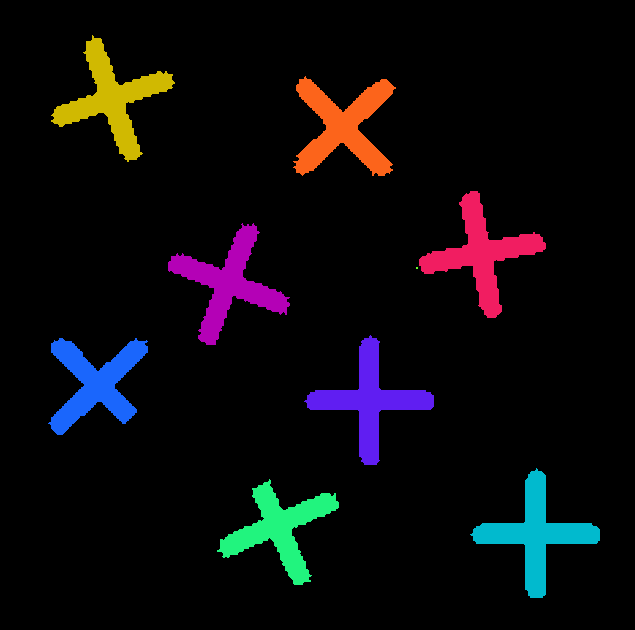

In [26]:
#Primero aplicamos Otsu para umbralizar la imagen de entrada
mask = Otsu(I)

#Obtenemos el array de píxeles etiquetados según la componente a la que pertenecen con la función previamente creada
final_comp_matrix = Label(mask)

#Normalizamos la matriz para obtener valores en escala de grises
final_comp_matrix = (final_comp_matrix/(len(np.unique(final_comp_matrix)) - 1)) * 255         
im = np.uint8(final_comp_matrix)

#Pasamos la imagen a RGB para representar en color las componentes 
im_RGB = Image.fromarray(im).convert('RGB')
r,g,b = np.zeros(I.shape), np.zeros(I.shape), np.zeros(I.shape)
for i in range(final_comp_matrix.shape[0]):
    for j in range(final_comp_matrix.shape[1]):
        if final_comp_matrix[i,j] != 0:
            r[i,j] = round(math.sin(0.024 * final_comp_matrix[i,j] + 0) * 127 + 128)
            g[i,j] = round(math.sin(0.024 * final_comp_matrix[i,j] + 2) * 127 + 128)
            b[i,j] = round(math.sin(0.024 * final_comp_matrix[i,j] + 4) * 127 + 128)

I2 = np.array(im_RGB)
I2[:,:,0] = r
I2[:,:,1] = g
I2[:,:,2] = b
im2 = Image.fromarray(I2)
im2


Ilustramos las cajas de mínima inclusión de las componentes, fijando el parámetro de entrada `bounding_box` a `True`.

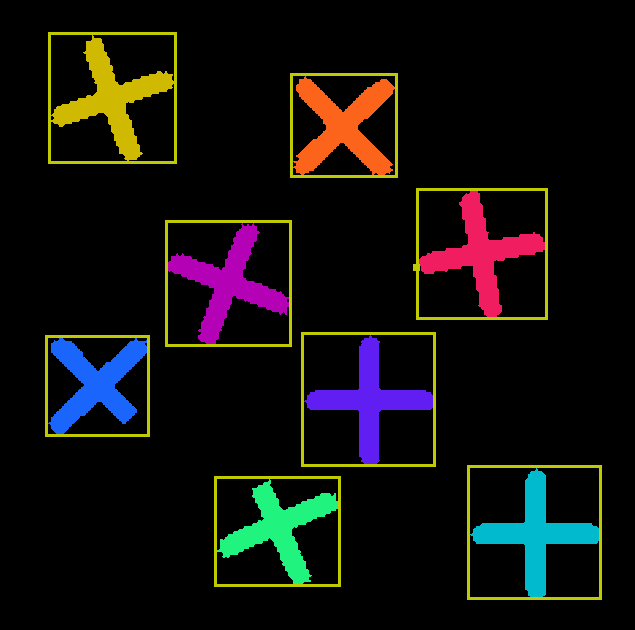

In [27]:
#Obtenemos el array de píxeles etiquetados según la componente a la que pertenecen y sus bounding boxes
final_comp_matrix = Label(mask,bounding_box= True)

#Normalizamos la matriz para obtener valores en escala de grises
final_comp_matrix = (final_comp_matrix/(len(np.unique(final_comp_matrix)) - 1)) * 255         
im = np.uint8(final_comp_matrix)

#Pasamos la imagen a RGB para representar en color las componentes 
im_RGB = Image.fromarray(im).convert('RGB')
r,g,b = np.zeros(I.shape), np.zeros(I.shape), np.zeros(I.shape)
for i in range(final_comp_matrix.shape[0]):
    for j in range(final_comp_matrix.shape[1]):
        if final_comp_matrix[i,j] != 0:
            r[i,j] = round(math.sin(0.024 * final_comp_matrix[i,j] + 0) * 127 + 128)
            g[i,j] = round(math.sin(0.024 * final_comp_matrix[i,j] + 2) * 127 + 128)
            b[i,j] = round(math.sin(0.024 * final_comp_matrix[i,j] + 4) * 127 + 128)

I2 = np.array(im_RGB)
I2[:,:,0] = r
I2[:,:,1] = g
I2[:,:,2] = b
im2 = Image.fromarray(I2)
im2

En este caso se detectan 9 objetos, aunque en realidad son 8 pues existe una componente muy pequeña que es considerada.